Some requirements:
You need to change the type of columns of the data frame to float64 for numerical variables and object for categorical variables
This code calculates three different relations between variables:
* Theils for two categorical variables
* Correlation ratio for a categorical and a numeric
* Pearson for two numeric variables

The scale of the first two ones are [0,1] but pearson is [-1,1]. Pay attention that the code changes the scales of all to [-1,1]. However, negative result of Theils and correlation matrix doen't interpret the same way as pearson does. 


In [8]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from collections import Counter
import scipy.stats as ss

In [2]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


In [3]:
# one category and one numeric. the order is important
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

In [4]:
#two categorical cariables. The order is important
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [11]:
#reading your dataset
trainData = pd.read_csv("train.tsv", delimiter='\t')
# do any preprocessing if needed. Such as changing the types to object and float64

In [12]:
relations = pd.DataFrame()
columns = trainData.columns[0:len(trainData.columns)]#columns labels
rows = trainData.columns[0:len(trainData.columns)] # rows
          
for j in range(0,len(columns)):
    for i in range(0,len(rows)):
        if (trainData[columns[j]].dtypes == 'float64'  and trainData[rows[i]].dtypes == 'float64'):
            u = trainData[columns[j]].corr( trainData[rows[i]])
            u = u*1
            relations.loc[rows[i],columns[j]] = u
        elif  (trainData[rows[i]].dtypes == 'O' and trainData[columns[j]].dtypes == 'float64'):
            u = correlation_ratio(trainData[rows[i]], trainData[columns[j]])
            u = u*1
            u=2*u-1 # normalizing to [-1,1]
            relations.loc[rows[i],columns[j]] = u
        elif (trainData[columns[j]].dtypes == 'O' and trainData[rows[i]].dtypes == 'float64' ):
            u = correlation_ratio(trainData[columns[j]], trainData[rows[i]])
            u = u*1
            u=2*u-1 # normalizing to [-1,1]
            relations.loc[rows[i],columns[j]] = u
        elif (trainData[columns[j]].dtypes == 'O' and trainData[rows[i]].dtypes == 'O'):
            u = theils_u(trainData[columns[j]], trainData[rows[i]])
            u = u*1
            u=2*u-1 # normalizing to [-1,1]
            relations.loc[rows[i],columns[j]] = u
relations.fillna(value=np.nan,inplace=True)

Plotting the heatmap of all relations 

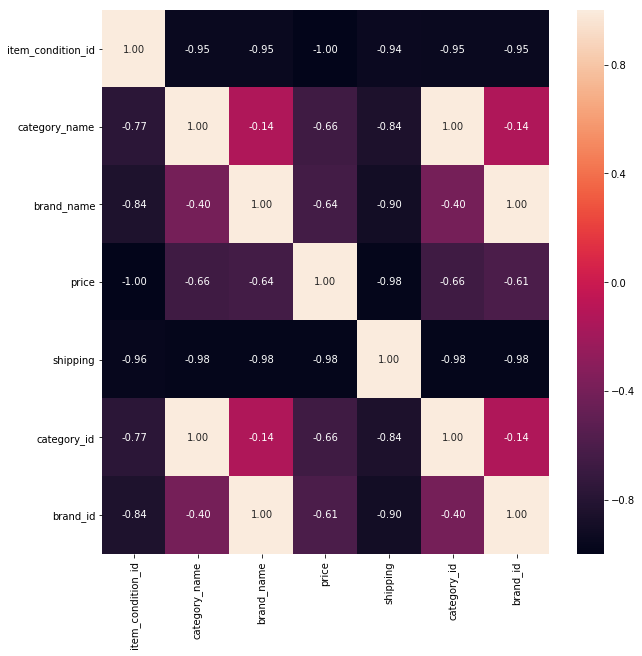

In [14]:
plt.figure(figsize=(10,10))
sb.heatmap(relations,annot=True,fmt='.2f')
plt.show()